In [1]:
from ultralytics import YOLO
import os
import cv2
from ensemble_boxes import soft_nms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

Matplotlib is building the font cache; this may take a moment.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/horken7/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# Load trained models with their best.pt weights
model_N = YOLO('models/YOLOv8n.pt') # Replace "/path/to/your" with the pat")  # YOLOv8n
model_S = YOLO('models/YOLOv8s.pt') # Replace "/path/to/your" with the pat")  # YOLOv8s
model_M = YOLO('models/YOLOv8m.pt') # Replace "/path/to/your" with the pat")  # YOLOv8m


In [4]:
# Path to the image
image_path ="annotation_nano-1024/test/images/1_png.rf.b750a6f25c23d63c670eaf64bf588108.jpg"

# Extract the filename
image_name = os.path.basename(image_path)

# Individual predictions
results_N = model_N(image_path, save=True, name=f"{image_name}_YOLOv8N")
results_S = model_S(image_path, save=True, name=f"{image_name}_YOLOv8S")
results_M = model_M(image_path, save=True, name=f"{image_name}_YOLOv8M")



image 1/1 /Users/horken7/Documents/particles/annotation_nano-1024/test/images/1_png.rf.b750a6f25c23d63c670eaf64bf588108.jpg: 640x640 57 Vs, 2 scal_bars, 36.1ms
Speed: 1.8ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/1_png.rf.b750a6f25c23d63c670eaf64bf588108.jpg_YOLOv8N

image 1/1 /Users/horken7/Documents/particles/annotation_nano-1024/test/images/1_png.rf.b750a6f25c23d63c670eaf64bf588108.jpg: 640x640 1 LCN, 3 MCVs, 58 Vs, 1 scal_bar, 56.4ms
Speed: 1.8ms preprocess, 56.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/1_png.rf.b750a6f25c23d63c670eaf64bf588108.jpg_YOLOv8S

image 1/1 /Users/horken7/Documents/particles/annotation_nano-1024/test/images/1_png.rf.b750a6f25c23d63c670eaf64bf588108.jpg: 640x640 23 LCNs, 1 MCV, 56 Vs, 1 scal_bar, 118.0ms
Speed: 1.5ms preprocess, 118.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/

In [5]:
def extract_boxes_confidences_labels(results):
    boxes = []
    scores = []
    labels = []
    
    for r in results[0].boxes.data:
        x1, y1, x2, y2, conf, cls = r.tolist()
        boxes.append([x1, y1, x2, y2])
        scores.append(conf)
        labels.append(int(cls))
    
    return boxes, scores, labels

# Data extraction for each model
boxes_N, scores_N, labels_N = extract_boxes_confidences_labels(results_N)
boxes_M, scores_M, labels_M = extract_boxes_confidences_labels(results_M)
boxes_S, scores_S, labels_S = extract_boxes_confidences_labels(results_S)

In [6]:
def normalize_boxes(boxes, width, height):
    return [[x1/width, y1/height, x2/width, y2/height] for x1, y1, x2, y2 in boxes]

# Load the image
image = cv2.imread(image_path)
height, width, channels = image.shape

# Normalize bounding boxes
boxes_N = normalize_boxes(boxes_N, width, height)
boxes_M = normalize_boxes(boxes_M, width, height)
boxes_S = normalize_boxes(boxes_S, width, height)

In [7]:
# Fusion of results
boxes_list = [boxes_N, boxes_S, boxes_M]
scores_list = [scores_N, scores_S, scores_M]
labels_list = [labels_N, labels_S, labels_M]

# Apply Soft-NMS
boxes_fused, scores_fused, labels_fused = soft_nms(
    boxes_list, scores_list, labels_list, iou_thr=0.3, sigma=0.5, thresh=0.5
)

# Final results
for i in range(len(boxes_fused)):
    print(f"Class: {labels_fused[i]}, Confidence: {scores_fused[i]:.2f}, Box: {boxes_fused[i]}")

Class: 0, Confidence: 0.69, Box: [    0.59627     0.65475     0.98522     0.98589]
Class: 0, Confidence: 0.51, Box: [   0.075367     0.35654     0.46141     0.67225]
Class: 1, Confidence: 0.74, Box: [    0.23305     0.88472     0.29491     0.94973]
Class: 1, Confidence: 0.53, Box: [    0.77819    0.035886     0.88451     0.13927]
Class: 3, Confidence: 0.97, Box: [    0.62049     0.29561     0.69569     0.38086]
Class: 3, Confidence: 0.97, Box: [    0.43031     0.61695     0.51084     0.69437]
Class: 3, Confidence: 0.97, Box: [    0.39251      0.9656     0.47082     0.99987]
Class: 3, Confidence: 0.97, Box: [    0.53119     0.68828     0.61311     0.77192]
Class: 3, Confidence: 0.97, Box: [     0.7692     0.28625     0.84983     0.37726]
Class: 3, Confidence: 0.96, Box: [   0.080869      0.2492     0.17224     0.32798]
Class: 3, Confidence: 0.96, Box: [    0.42449      0.7859     0.49501     0.85681]
Class: 3, Confidence: 0.96, Box: [    0.71579     0.59777     0.81967     0.69519]
Clas

1 2


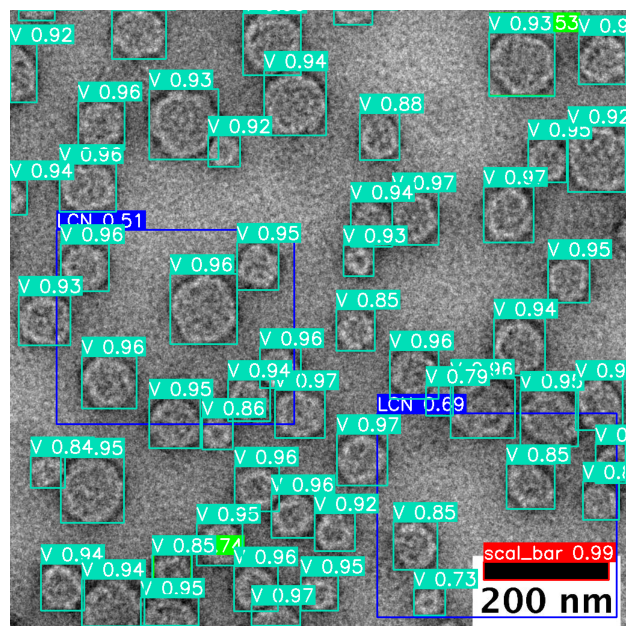

In [8]:
# color dictionary by class
class_colors = {
    0: (0, 0, 255),    # Class 0
    1: (0, 255,0),  # Class 1
    2: (243, 243,0), # Class 2
    3: (0, 223, 183),   # Class 3
    4: (255, 0, 0)      # Class 4
}

# Dictionary of class names
class_labels = {
    0: "LCN",        # Class 0
    1: "MCV",        # Class 1
    2: "TMCV",       # Class 2
    3: "V",          # Class 3
    4: "scal_bar"    # Class 4
}

# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB for Matplotlib

# Get image dimensions
height, width, _ = image.shape
f = height / 1024
a = int(f * 1)
b = int(f * 2)
print(a, b)

# Denormalize bounding box coordinates (they are between 0 and 1 after WBF)
def denormalize_box(box, width, height):
    x1, y1, x2, y2 = box
    return [int(x1 * width), int(y1 * height), int(x2 * width), int(y2 * height)]

# Draw fused bounding boxes
for i in range(len(boxes_fused)):
    box = denormalize_box(boxes_fused[i], width, height)
    score = scores_fused[i]
    label = labels_fused[i]

    # Get the associated color and class name
    color = class_colors.get(label, (255, 255, 255))  # White if class is undefined
    label_name = class_labels.get(label, f"Class {label}")

    # Draw the bounding box
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)
    
    # Format the label: "ClassName Confidence"
    text = f"{label_name} {score:.2f}"
    
    # Get text size to draw a background
    (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, a, b)

    # ✅ Check if the bounding box color is white
    if color == (243, 243, 243):  # White color (Class 2)
        text_color = (0, 0, 0)    # Black text for contrast
    else:
        text_color = (255, 255, 255)  # White text otherwise

    # Draw a background behind the text for better readability
    cv2.rectangle(image, (box[0], box[1] - text_height - baseline), (box[0] + text_width, box[1]), color, -1)
    
    # Add the text
    cv2.putText(image, text, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, a, text_color, b)

# Display the image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(image)
# plt.title("Fusion Results (Weighted Boxes Fusion)")
plt.axis("off")
plt.savefig('prediction_N_S_M.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Path and parameters
plt.show()

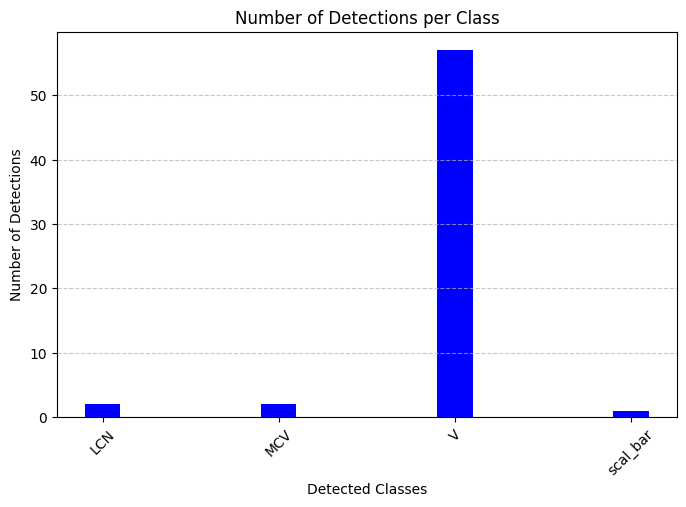

In [9]:
# Histogram of classes detected
def plot_class_distribution(labels_fused, class_labels):
    class_counts = Counter(labels_fused)
    
    plt.figure(figsize=(8, 5))
    plt.bar([class_labels.get(cls, f"Class {cls}") for cls in class_counts.keys()], 
            class_counts.values(), color='blue', width=0.2)
    plt.xlabel("Detected Classes")
    plt.ylabel("Number of Detections")
    plt.title("Number of Detections per Class")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('nbr_class.png', dpi=300, bbox_inches='tight')  # Path and parameters
    plt.show()

plot_class_distribution(labels_fused, class_labels)


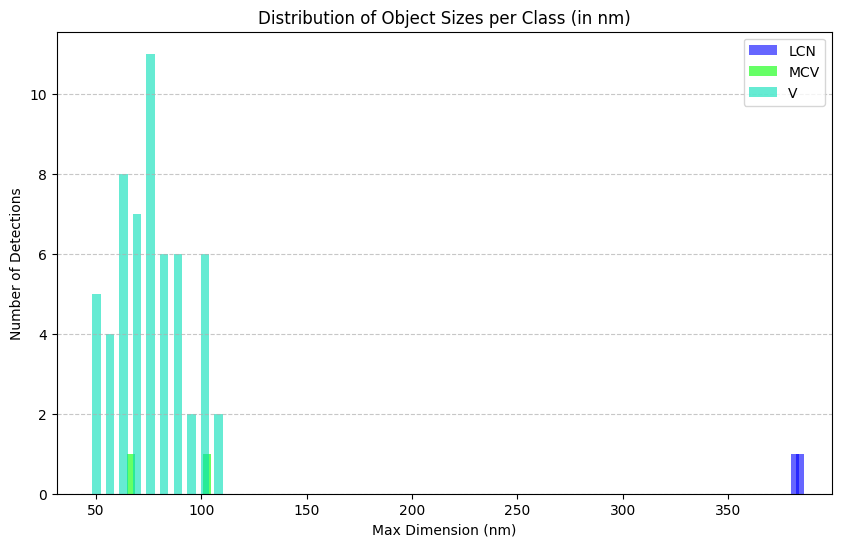

  Class  Mean Max Dimension (nm)  Std Dev (nm)
0   LCN               381.250000      1.442308
1   MCV                84.615385     20.192308
2     V                77.564103     16.645892
Results saved as 'object_size_distribution.csv'


In [10]:
# Étape 1 : Trouver la longueur de la barre d'échelle en pixels
scale_bar_length_nm = 200  # La barre d'échelle correspond à 200 nm
scale_bar_pixels = None

for i, label in enumerate(labels_fused):
    if label == 4:  # Classe 'scal_bar'
        x1, _, x2, _ = denormalize_box(boxes_fused[i], width, height)
        scale_bar_pixels = x2 - x1  # Longueur de la barre d'échelle en pixels
        break  # On ne prend qu'une seule barre d'échelle

# Vérifier si la barre d'échelle a été trouvée
if scale_bar_pixels:
    pixel_to_nm = scale_bar_length_nm / scale_bar_pixels  # Conversion pixel → nm

    # Étape 2 : Calculer la taille maximale des objets détectés en nm
    object_sizes_nm = {cls: [] for cls in set(labels_fused) if cls != 4}  # Exclure la scale bar

    for i, label in enumerate(labels_fused):
        if label != 4:  # Ignorer la scale bar
            x1, y1, x2, y2 = denormalize_box(boxes_fused[i], width, height)
            length_nm = (x2 - x1) * pixel_to_nm  # Longueur convertie en nm
            width_nm = (y2 - y1) * pixel_to_nm  # Largeur convertie en nm
            max_dimension_nm = max(length_nm, width_nm)  # On prend la plus grande des deux
            object_sizes_nm[label].append(max_dimension_nm)

    # Étape 3 : Tracer un histogramme des tailles maximales en nm pour chaque classe
    plt.figure(figsize=(10, 6))
    for cls, values in object_sizes_nm.items():
        plt.hist(values, bins=10, alpha=0.6, width=4, color=np.array(class_colors.get(cls, (255, 255, 255))) / 255.0, label=class_labels.get(cls, f"Class {cls}"))

    plt.xlabel("Max Dimension (nm)")
    plt.ylabel("Number of Detections")
    plt.title("Distribution of Object Sizes per Class (in nm)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('distribution.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Path and parameters
    plt.show()
    
    # Étape 4 : Calculer la moyenne et l'écart-type des tailles maximales en nm
    summary_sizes_nm = []
    for cls, values in object_sizes_nm.items():
        if values:
            mean_size_nm = np.mean(values)
            std_dev_size_nm = np.std(values)
            summary_sizes_nm.append([class_labels.get(cls, f"Class {cls}"), mean_size_nm, std_dev_size_nm])

    
    # Créer un DataFrame pour affichage
    df_summary_sizes_nm = pd.DataFrame(summary_sizes_nm, columns=["Class", "Mean Max Dimension (nm)", "Std Dev (nm)"])

    
    # Display the DataFrame in console
    print(df_summary_sizes_nm)

    # Save results to CSV
    df_summary_sizes_nm.to_csv("object_size_distribution.csv", index=False)
    print("Results saved as 'object_size_distribution.csv'")

else:
    print("Scale bar not found. Unable to calculate object sizes in nanometers.")

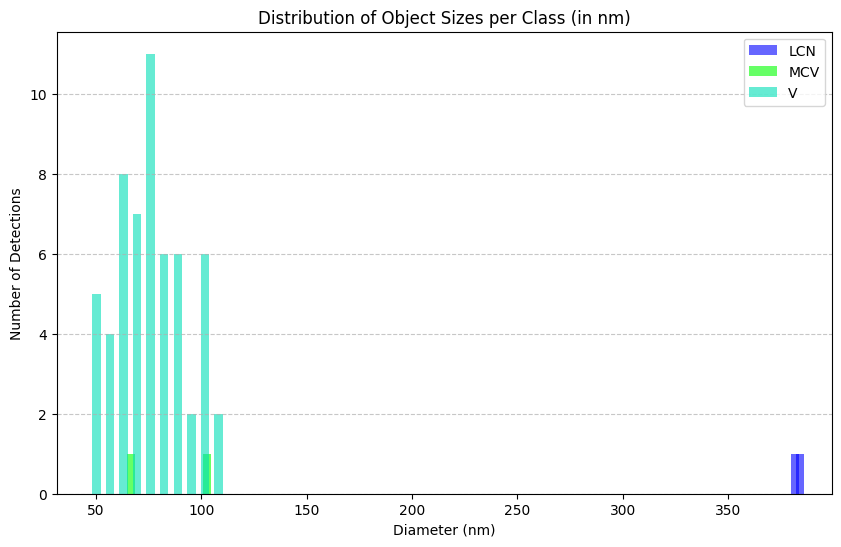

  Class  Mean Max Dimension (nm)  Std Dev (nm)
0   LCN               381.250000      1.442308
1   MCV                84.615385     20.192308
2     V                77.564103     16.645892
Results saved as 'object_size_distribution.csv'


In [11]:
# Determine the length of the scale bar in pixels
scale_bar_length_nm = 200  # The scale bar corresponds to 200 nm
scale_bar_pixels = None

for i, label in enumerate(labels_fused):
    if label == 4:  # Class 'scal_bar'
        x1, _, x2, _ = denormalize_box(boxes_fused[i], width, height)
        scale_bar_pixels = x2 - x1  # Scale bar length in pixels
        break  # Only one scale bar is needed

# Verify if the scale bar was found
if scale_bar_pixels:
    pixel_to_nm = scale_bar_length_nm / scale_bar_pixels  # Convert pixels to nm

    # Calculate the maximum size of detected objects in nm
    object_sizes_nm = {cls: [] for cls in set(labels_fused) if cls != 4}  # Exclude the scale bar

    for i, label in enumerate(labels_fused):
        if label != 4:  # Ignore the scale bar
            x1, y1, x2, y2 = denormalize_box(boxes_fused[i], width, height)
            length_nm = (x2 - x1) * pixel_to_nm  # Convert length to nm
            width_nm = (y2 - y1) * pixel_to_nm  # Convert width to nm
            max_dimension_nm = max(length_nm, width_nm)  # Take the larger of the two
            object_sizes_nm[label].append(max_dimension_nm)

    # Plot a histogram of maximum object sizes in nm for each class
    plt.figure(figsize=(10, 6))
    for cls, values in object_sizes_nm.items():
        plt.hist(values, bins=10, alpha=0.6, width=4, 
                 color=np.array(class_colors.get(cls, (255, 255, 255))) / 255.0, 
                 label=class_labels.get(cls, f"Class {cls}"))

    plt.xlabel("Diameter (nm)")
    plt.ylabel("Number of Detections")
    plt.title("Distribution of Object Sizes per Class (in nm)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('distribution.png', dpi=300, bbox_inches='tight', pad_inches=0)  # Path and parameters
    plt.show()
    
    # Step 4: Compute the mean and standard deviation of maximum object sizes in nm
    summary_sizes_nm = []
    for cls, values in object_sizes_nm.items():
        if values:
            mean_size_nm = np.mean(values)
            std_dev_size_nm = np.std(values)
            summary_sizes_nm.append([class_labels.get(cls, f"Class {cls}"), mean_size_nm, std_dev_size_nm])

    # Create a DataFrame for display
    df_summary_sizes_nm = pd.DataFrame(summary_sizes_nm, columns=["Class", "Mean Max Dimension (nm)", "Std Dev (nm)"])

    # Display the DataFrame in the console
    print(df_summary_sizes_nm)

    # Save results to CSV
    df_summary_sizes_nm.to_csv("object_size_distribution.csv", index=False)
    print("Results saved as 'object_size_distribution.csv'")

else:
    print("Scale bar not found. Unable to calculate object sizes in nanometers.")